In [27]:
from tqdm import tqdm
from requests import request
import pandas as pd
from os import listdir
from os.path import isfile, join
import matplotlib.pyplot as plt

In [28]:
res = request("GET", 'https://www.smard.de/app/chart_data/4359/DE/index_hour.json')
timestamps = res.json()["timestamps"]

In [29]:
time_series = []
for timestamp in tqdm(timestamps):
    res = request("GET", "https://www.smard.de/app/chart_data/4359/DE/4359_DE_hour_" +str(timestamp)+".json")
    body = res.json()["series"]
    time_series += body

100%|██████████| 467/467 [00:27<00:00, 17.30it/s]


In [30]:
residual_load_dataset = pd.DataFrame(time_series)
residual_load_dataset.index = [pd.Timestamp(x, unit='ms') for x in residual_load_dataset.iloc[:, 0]]
residual_load_dataset = residual_load_dataset.drop(columns=0)
residual_load_dataset = residual_load_dataset.dropna()
residual_load_dataset.columns = ["Residual Load"]
residual_load_dataset.head()

,Residual Load
2014-12-31 23:00:00,35955.75
2015-01-01 00:00:00,34641.00
2015-01-01 01:00:00,32909.25
2015-01-01 02:00:00,31548.00
2015-01-01 03:00:00,30773.50


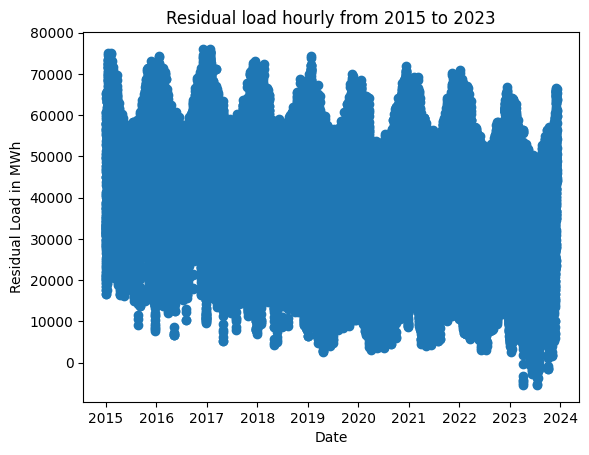

In [31]:
plt.scatter(residual_load_dataset.index, residual_load_dataset["Residual Load"])
plt.title("Residual load hourly from 2015 to 2023")
plt.xlabel("Date")
plt.ylabel("Residual Load in MWh")
plt.show()

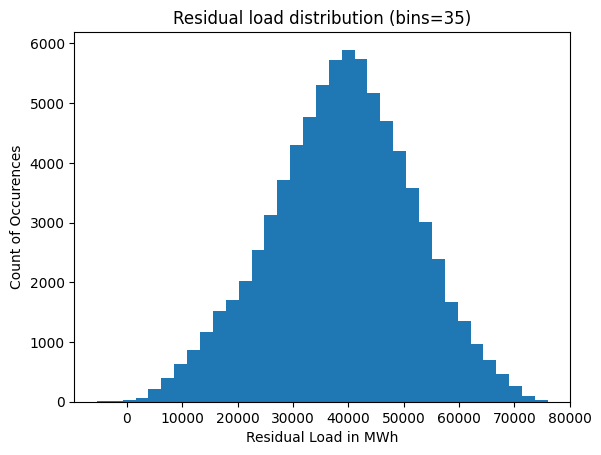

In [32]:
plt.hist(residual_load_dataset["Residual Load"], bins=35)
plt.title("Residual load distribution (bins=35)")
plt.xlabel("Residual Load in MWh")
plt.ylabel("Count of Occurences")
plt.show()

In [33]:
def extract_dwd_data(residual_load_dataset, station_id):
    
    station_data = [x for x in listdir() if station_id in x]
    
    wind_data = pd.read_csv([x for x in station_data if "produkt_f" in x][0], sep=";").iloc[-80000:]
    solar_data = pd.read_csv([x for x in station_data if "produkt_sd" in x][0], sep=";").iloc[-80000:]
    temperature_data = pd.read_csv([x for x in station_data if "produkt_tu" in x][0], sep=";").iloc[-80000:]
    precipitation_data = pd.read_csv([x for x in station_data if "produkt_rr" in x][0], sep=";").iloc[-80000:]
    
    wind_data.index = [pd.to_datetime(x, format="%Y%m%d%H") for x in wind_data["MESS_DATUM"]]
    wind_data = wind_data.drop(columns="MESS_DATUM")
    wind_data = wind_data.rename(columns={"  FF": "Wind Velocity for Station " + station_id})
    solar_data.index = [pd.to_datetime(x, format="%Y%m%d%H") for x in solar_data["MESS_DATUM"]]
    solar_data = solar_data.drop(columns="MESS_DATUM")
    solar_data = solar_data.rename(columns={"SD_SO": "Sun Duration for Station " + station_id})
    temperature_data.index = [pd.to_datetime(x, format="%Y%m%d%H") for x in temperature_data["MESS_DATUM"]]
    temperature_data = temperature_data.drop(columns="MESS_DATUM")
    temperature_data = temperature_data.rename(columns={"TT_TU": "Air Temperature for Station " + station_id})
    precipitation_data.index = [pd.to_datetime(x, format="%Y%m%d%H") for x in precipitation_data["MESS_DATUM"]]
    precipitation_data = precipitation_data.drop(columns="MESS_DATUM")
    precipitation_data = precipitation_data.rename(columns={"  R1": "Precipitation Amount for Station " + station_id})

    residual_load_dataset = pd.concat([residual_load_dataset, wind_data["Wind Velocity for Station " + station_id], solar_data["Sun Duration for Station " + station_id], temperature_data["Air Temperature for Station " + station_id], precipitation_data["Precipitation Amount for Station " + station_id]], axis=1)
    
    return residual_load_dataset

In [34]:
for i in ["02014", "03987", "03379", "04928"]:
    residual_load_dataset = extract_dwd_data(residual_load_dataset, i)

In [35]:
residual_load_dataset = residual_load_dataset.dropna()

In [36]:
residual_load_dataset["Quarter"] = residual_load_dataset.index
residual_load_dataset["Quarter"] = residual_load_dataset["Quarter"].dt.quarter

In [37]:
residual_load_dataset["Month"] = [x.month for x in list(residual_load_dataset.index)]

In [38]:
cols = residual_load_dataset.columns.tolist()
cols = cols[1:] + [cols[0]]
residual_load_dataset = residual_load_dataset[cols]
residual_load_dataset 

,Wind Velocity for Station 02014,Sun Duration for Station 02014,Air Temperature for Station 02014,Precipitation Amount for Station 02014,Wind Velocity for Station 03987,Sun Duration for Station 03987,Air Temperature for Station 03987,Precipitation Amount for Station 03987,Wind Velocity for Station 03379,Sun Duration for Station 03379,Air Temperature for Station 03379,Precipitation Amount for Station 03379,Wind Velocity for Station 04928,Sun Duration for Station 04928,Air Temperature for Station 04928,Precipitation Amount for Station 04928,Quarter,Month,Residual Load
2015-01-01 03:00:00,3.7,0.0,2.8,0.0,6.0,0.0,3.5,0.0,-999.0,0.0,-3.2,0.0,1.0,0.0,0.5,0.0,1,1,30773.50
2015-01-01 04:00:00,4.2,0.0,2.5,0.0,6.7,0.0,2.6,0.0,-999.0,0.0,-3.3,0.0,1.8,0.0,0.4,0.0,1,1,30040.75
2015-01-01 05:00:00,3.0,0.0,2.0,0.0,5.6,0.0,2.2,0.0,-999.0,0.0,-4.3,0.0,3.2,0.0,0.5,0.0,1,1,28161.50
2015-01-01 06:00:00,3.8,0.0,1.9,0.0,5.7,0.0,2.1,0.0,-999.0,0.0,-4.5,0.0,2.1,0.0,0.6,0.0,1,1,27767.25
2015-01-01 07:00:00,3.1,0.0,1.4,0.0,5.5,0.0,2.7,0.0,-999.0,0.0,-3.9,0.0,0.2,0.0,0.6,0.0,1,1,28531.25
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-12-31 16:00:00,8.6,0.0,16.3,0.0,6.1,0.0,16.3,0.0,1.4,0.0,12.8,0.0,3.8,0.0,17.3,0.0,4,12,15915.75
2022-12-31 17:00:00,7.1,0.0,15.9,0.0,7.7,0.0,16.6,0.0,1.8,0.0,11.4,0.0,3.9,0.0,17.2,0.0,4,12,16438.75
2022-12-31 18:00:00,7.4,0.0,15.7,0.0,8.6,0.0,16.4,0.0,2.5,0.0,11.9,0.0,3.5,0.0,16.6,0.0,4,12,15153.50
2022-12-31 19:00:00,6.7,0.0,16.3,0.0,6.9,0.0,15.8,0.0,2.2,0.0,11.9,0.0,5.1,0.0,15.8,0.0,4,12,11943.75


In [39]:
from sklearn.model_selection import train_test_split

X_test, X_train, y_test, y_train = train_test_split(residual_load_dataset.drop(columns="Residual Load"), residual_load_dataset["Residual Load"])

In [40]:
residual_load_dataset.to_csv("Residual Load Dataset.csv")